# **MODULE 1: Setting up and exploring a simple TVB Simulation**




#### At the end of this module participants should be able to: 
           1. understand the model parameter inputs required to produce bistable dynamics
           2. load in and visualize example TVB input data
           3. run a simple TVB simulation using the Montbrio model
           4. explore model outputs
           
A significant portion of our workflow is adapted from the [Virtual Aging Brain GitHub Repository](https://github.com/ins-amu/virtual_aging_brain) and the [Virtual Ageing Showcase on EBRAINS](https://wiki.ebrains.eu/bin/view/Collabs/sga3-d1-2-showcase-1/).

Sample data was obtained from the [Amsterdam PIOP2 Open Dataset](https://nilab-uva.github.io/AOMIC.github.io/) and prepared for simulation using the [TVB-UKBB MRI Processing Pipeline](https://github.com/McIntosh-Lab/tvb-ukbb).

<br>

---



<br>

### *1. MontbrioPazóRoxin Model Review*

   This neural mass model describes each node’s dynamics by the:  
       <span style="color:orange;">*- average membrane potential*</span> V<sub>i</sub>(t)  
       <span style="color:green;">*- average firing rate*</span> r<sub>i</sub>(t)  
       <span style="color:blue;">*Input current*</span> I<sub>i</sub>(t) gives rise to oscillatory dynamics  
       
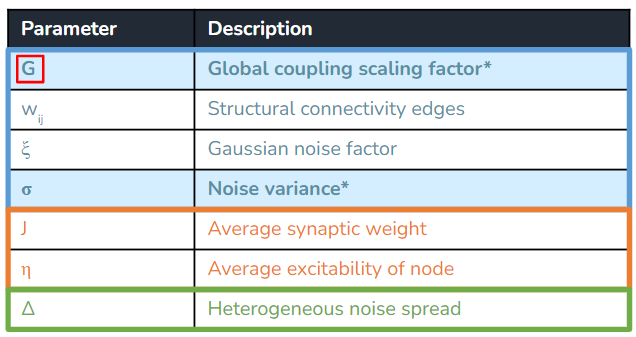
       
       
   Pay special attention to **G** and **noise variance** (which we'll refer to as "noise" for the remainder of this session).
       
       
**The differential equations for the model are:** 


<!-- 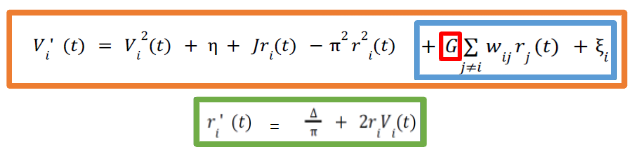 -->
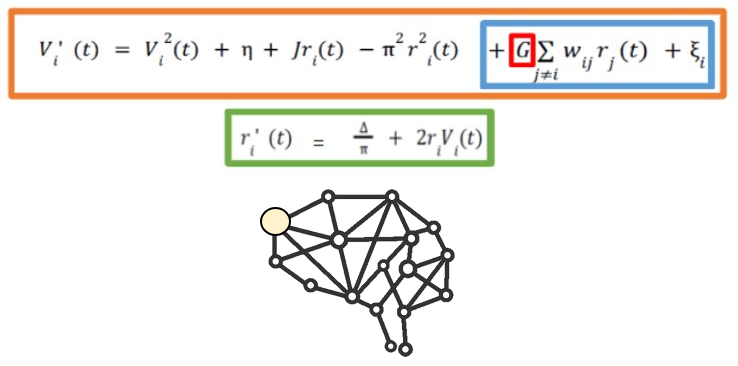






<br>

### *2. Reviewing the concept of bistability*
**Functional connectivity dynamics (FCD)** reflects the brain's capacity to switch between cognitive states. A node's oscillatory dynamics between a *down-state fixed point* and *up-state stable focus* in phase space (i.e., a **bistable regime**) ensures a switching behaviour in the data. The switching behaviour is thought be representative of real brain dynamics and fluidity (Rabuffo et al., 2021; Fousek et al., 2022, Lavanga et al., 2023).

*Example bistability plot*:

![rv_with_traces-smallest.gif](./_img/rv_with_traces_smaller-looped.gif)

### *3. Load in the required packages for this notebook*

In [ ]:
%pylab inline
import sys, os, time
import numpy as np
import src
from src import viz
from src import simulation
from src import analysis
from tvb.simulator.lab import *
from tvb.simulator.backend.nb_mpr import NbMPRBackend
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter

### *4. Visualizing the inputs for TVB*

The following steps/code encompass the necessary step for loading in and visualizing data from an example subject from the Amsterdam Dataset. 

Let's take a look at sub-0001. We first load in the structural connectivity (SC) matrix, `weights.txt` and inspect it.

In [ ]:
# Declare the subject directory
sub_dir='/tvb_node/tvb/tvb-node/Session_Materials/data/sub-0001/' #MODIFY


# Load in the sub-0001 SC file 
sc_path = os.path.join(sub_dir,'weights.txt') #MODIFY
sc = np.loadtxt(sc_path, delimiter=' ')

# Check shape (the shape should be the number of ROIs x number of ROIs)
print(f"Shape of Structural Connectivity Matrix is {np.shape(sc)}")

# Check for NaNs
nan_indices = np.argwhere(np.isnan(sc))
nans_exist=0
for index in nan_indices:
    nans_exist=1 
    print(f"NaN found at index: {index}")
if nans_exist==0:
    print("No NaNs found!")

Let's generate a heatmap and visualize the SC matrix:

Let's visualize our SC weights in a log10 scale instead. **We log10 our weights for visualization only, not simulation!**:

In [ ]:
#Visualize the log(10) SC weights


# Heatmap
log_matrix = np.log10(np.where(sc == 0, np.nan, sc))
plt.imshow(log_matrix, interpolation='none', cmap='viridis')
colorbar=plt.colorbar()
colorbar.set_label('log10 Probability of Connection', rotation=270, labelpad=20) 
# Overlay black color on the locations where the original matrix had 0 values
rows, cols = sc.shape
overlay = np.zeros((rows, cols, 4))  # Initialize a transparent overlay
overlay[sc == 0] = [0, 0, 0, 1]  # Set cells with log(0) to black ([R, G, B, Alpha])
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.title('Heatmap of log10(SC) Values - 0 connections black')
heatmap=plt.imshow(overlay, interpolation='none')
plt.grid(False)
plt.show()

# Histogram
values = log_matrix.flatten()
values_masked = ma.masked_where(values == np.log10(1e-10), values)
plt.hist(values_masked.compressed(), bins=50, alpha=0.75)
plt.xlabel('log10 Probability of Connection')
plt.ylabel('Frequency')
plt.title('Histogram of log10(SC) Values - 0 connections not visualized')
plt.grid(True)
plt.show()

SC is our most important input, but let's also inspect some of the others: centre locations, cortical properties, hemisphere properties, and tract lengths (TL). These can be found in `centres.txt`, `hemisphere.txt`, `cortical.txt`, and `tract_lengths.txt`, respectively.

### *5. Setting up a simple TVB simulation*

The next steps include the code for a simple TVB simulation. We'll first load the inputs we explored above into a connectivity structure.


In [ ]:
# Define the function to Load in the SC file - function to be called later
def get_connectivity(scaling_factor,sc_path):
        SC = np.loadtxt(sc_path)
        SC = SC / scaling_factor
        conn = connectivity.Connectivity(
                weights = SC,
                tract_lengths=np.ones_like(SC),
                centres = np.zeros(np.shape(SC)[0]),
                speed = np.r_[np.Inf]
        )
        conn.compute_region_labels()

        return conn
    

scaling_factor=1     #scaling the SC matrix - strength of connections not changed when 1 - no normalization
sc_path = os.path.join(sub_dir,'weights.txt')


You will select the neural mass model *MontbrioPazoRoxin*. 

You will also need to specify a number of model parameter values. 

The values for the following model parameters are set in accordance to previous literature to ensure a bistable regime (_see [The Virtual Aging Brain](https://www.sciencedirect.com/science/article/pii/S1053811923005542?via%3Dihub) by Lavanga et al. 2023, [Macroscopic Description for Networks of Spiking Neurons](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.5.021028) by Montbrio, Pazo, Roxin 2015, [Neuronal Cascades Shape Whole-Brain Functional Dynamics at Rest](https://www.eneuro.org/content/8/5/ENEURO.0283-21.2021) by Rabuffo et al. 2021 for more details on each model parameter_):
- **η**   = -4.6
- **J**     = 14.5
- **Δ** = 0.7
- **τ**   = 1.

We will be exploring a *single* simulation for a specific G-noise value combination.

In [ ]:
# Specify the model and model initial parameter values
G=1.993
nsigma=0.04
dt=0.005    #integration step size

sim_len=6e3 #length of simulation - units depend on setup

# Set up a simulation object
sim = simulator.Simulator(
    connectivity = get_connectivity(scaling_factor,sc_path),
    model = models.MontbrioPazoRoxin(
        eta   = np.r_[-4.6],
        J     = np.r_[14.5],
        Delta = np.r_[0.7],
        tau   = np.r_[1.],
    ),
    coupling = coupling.Linear(a=np.r_[G]),
    integrator = integrators.HeunStochastic(
        dt = dt,
        noise = noise.Additive(nsig=np.r_[nsigma, nsigma*2])
    ),
    monitors = [monitors.TemporalAverage(period=0.1)]
).configure()

Let's run the simulation now!

In [ ]:
# Run the simulation
runner = NbMPRBackend()

start_time = time.time() #mark start time 

(tavg_t, tavg_d), = runner.run_sim(sim, simulation_length=sim_len)   #run the sim

end_time = time.time() #mark end time
elapsed_time = end_time - start_time
print(f"Simulation took: {elapsed_time} seconds")

tavg_t *= 10 #convert simulation timepoints to ms


In [ ]:
#Save the outputs

np.save(os.path.join(sub_dir,f'sub-0001_G-{G}_noise-{nsigma}_dt-{dt}_tavg_d.npy'), tavg_d) #data vector
np.save(os.path.join(sub_dir,f'sub-0001_G-{G}_noise-{nsigma}_dt-{dt}_tavg_t.npy'), tavg_t) #time vector

### *6. TVB Simulation outputs*
#### Initial Inspection
Let's look at the outputs tavg_d (data) and tavg_t (timepoints):

In [ ]:
tavg_t_shape=np.shape(tavg_t)
print(f"Shape of tavg_t is {tavg_t_shape}")
print(f"We have {tavg_t_shape[0]} timepoints")

In [ ]:
tavg_d_shape=np.shape(tavg_d)
print(f"Shape of tavg_d is {tavg_d_shape}")
print(f"We have {tavg_d_shape[0]} timepoints, {tavg_d_shape[1]} state variables, {tavg_d_shape[2]} ROIs, {tavg_d_shape[3]} modes")

#### Firing Rate and Membrane Potential
Let's look at the firing rate and membrane potential over the time series for a few ROIs:

In [ ]:
#Plot the simulated data - firing rate
ROIs_to_plot=range(10)
ax = viz.plot_ts_stack(tavg_d[:, 0, ROIs_to_plot, 0], x=tavg_t[:]/1000, width=20)
ax.set(xlabel='time [s]');
ax.set(ylabel='ROI');
ax.set_yticklabels([f"{t+1:.0f}" for t in ROIs_to_plot]);
ax.set_title("Simulated firing rate");


In [ ]:
#Plot the simulated data - membrane potential
ROIs_to_plot=range(10)
ax = viz.plot_ts_stack(tavg_d[:, 1, ROIs_to_plot, 0], x=tavg_t[:]/1000, width=20)
ax.set(xlabel='time [s]');
ax.set(ylabel='ROI');
ax.set_yticklabels([f"{t+1:.0f}" for t in ROIs_to_plot]);
ax.set_title("Simulated membrane potential");


#### Brain Regional Activity Trajectory Plot - Bistability
From a quick inspection, it looks like membrane potential and firing rate spike together. We can visualize their relationship and qualitatively assess bistability with a bistability plot:

In [ ]:
# Plot a bistability plot for an example node

roi=5 #MODIFY
start = 300 #MODIFY
end = 3000 #MODIFY

#Extract relevant data
r = tavg_d[start:end, 0, roi, 0]
v = tavg_d[start:end, 1, roi, 0]

r_vect = savgol_filter(r,15,3)
v_vect = savgol_filter(v,15,3)

data_rv = pd.DataFrame({'r':r_vect,'v':v_vect})

#Plot
f,ax = plt.subplots(figsize=(5,5))
sns.set_theme(style="darkgrid")
sns.lineplot(data=data_rv, x="r", y="v",sort=False,lw=2,color = "blue")

ax.set_xlabel("Firing Rate",fontsize=15)
ax.set_ylabel("Membrane Potential",fontsize=15);

#### Creating Simulated BOLD Data
Using the outputs from our simulation, we can generate the associated simulated BOLD data with our Balloon/Windkessel Model:

In [ ]:
#Apply the Windkessel model to the simulated data to derive the BOLD time series with TR=2000ms
bold_t, bold_d = simulation.tavg_to_bold(tavg_t, tavg_d, tavg_period=1, connectivity=sim.connectivity, svar=0, decimate=2000) 

# Cut the initial transient (e.g., 16 seconds). First ~15 seconds of the balloon model output should be discarded 
bold_t = bold_t[8:] 
bold_d = bold_d[8:]

#### BOLD Carpet Plot
Let's visualize this simulated BOLD data in a carpet plot:

In [ ]:

#Visualize carpet plot of the BOLD data
original_x = np.arange(bold_d.shape[0])  #code to prettyprint x axis in sec
doubled_x = original_x * 2  #code to prettyprint x axis in sec

plt.imshow(bold_d[:,0,:,0].T, aspect='auto', interpolation='none',extent=[doubled_x.min(), doubled_x.max(), 0, bold_d.shape[2]])

plt.title(f"G: {G}, Noise: {nsigma} - BOLD Carpet Plot")
plt.colorbar(label='BOLD amplitude')
plt.xlabel("Time (s)")
plt.ylabel("ROI")
plt.grid(False)                 

# Display the plot
plt.show()

#### FCD and FCD Variance
We can also look at our simulated FCD Matrix by correlating the FC of various time windows from the above simulated BOLD timeseries. We can also generate FCD Variance from an upper triangle of the simulated FCD matrix:

In [ ]:
#Compute FCD Matrix
FCD, _, _ = analysis.compute_fcd(bold_d[:,0,:,0], win_len=5) #our typical 20 timepoint, 40 second window is not feasible here with a 1 minute sim
#Visualize
plt.imshow(FCD)
plt.title(f"G: {G}, Noise: {nsigma} - FCD Plot")
plt.colorbar(label='Correlation')
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")
plt.grid(False)                     

print(f"FCD Variance - {np.var(np.triu(FCD, k=5))}") #we only grab the triu from above 5th diagonal above main to avoid autocorrelations